In [1]:
import tensorflow as tf
import tensorflow_federated as tff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2023-04-23 23:34:20.144806: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 23:34:20.173831: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 23:34:20.174421: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 23:34:20.695077: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import collections
import time

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from joblib import dump, load

In [3]:
NB_CLIENTS = 9
TEST_CLIENT = None

DATA_PATH_PATTERN = "../data/Device #%d.csv"
PRETRAINED_MODEL = "../models/dl.h5"

WHOLE_CLASSES = ['benign', 'm_scan', 'm_ack', 'm_syn', 'm_udp', 'm_udpplain', 'g_combo', 'g_junk', 'g_scan', 'g_tcp', 'g_udp']
BINARY_MODE = False
BATCH_SIZE = 64
NB_CLASSES = len(WHOLE_CLASSES)
NB_EPOCHES = 1
NB_ROUNDS = 10
MX_RECORDS = 100000

In [4]:
global le, sc
sc = load('../models/std_scaler.bin')
le = load('../models/lab_encoder.bin')


def preprocessor(_client_data: pd.DataFrame):
    global sc, le
    _client_data = shuffle(_client_data)
    _x = _client_data.drop(["type"], axis=1)
    _y = _client_data["type"]
    _x = sc.transform(_x)
    
    if le is None:
        le = LabelEncoder()
        le.fit(WHOLE_CLASSES)
    
    if BINARY_MODE:
        _y = (_y == "benign").astype(int)
    else:
        _y = le.transform(_y)
        _y = tf.keras.utils.to_categorical(_y, num_classes=NB_CLASSES)
        
    return _x, _y


def make_dataset(_x, _y):
    return tf.data.Dataset.from_tensor_slices(
        collections.OrderedDict(
            x=tf.constant(_x),
            y=tf.constant(_y)
        )
    )


def client_data(_x, _y):
    indicies = np.random.randint(len(_x), size=MX_RECORDS)
    _client_data = make_dataset(_x[indicies], _y[indicies])
    return _client_data.shuffle(MX_RECORDS).batch(BATCH_SIZE).repeat(NB_EPOCHES)

In [5]:
global raw_clients_data, processed_data
raw_clients_data = []
processed_data = []
test_raw_data = None

for idx in range(NB_CLIENTS):
    raw_content = shuffle(pd.read_csv(DATA_PATH_PATTERN % (idx + 1)))
    
    if TEST_CLIENT is not None:
        if TEST_CLIENT == idx:
            test_raw_data = raw_content
            continue
    else:
        train_data, test_data = train_test_split(raw_content, test_size=0.2, random_state=101)

        if test_raw_data is None:
            test_raw_data = test_data
        else:
            test_raw_data = pd.concat([test_raw_data, test_data])
        raw_content = train_data
        
    raw_clients_data.append(raw_content)
    processed_data.append(preprocessor(raw_content))

/opt/Anaconda310/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/Anaconda310/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/Anaconda310/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/Anaconda310/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/Anaconda310/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/Anaconda310/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature nam

In [6]:
train_client_data = [client_data(*data) for data in processed_data]
element_spec = train_client_data[0].element_spec

test_x, test_y = preprocessor(test_raw_data)

/opt/Anaconda310/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [7]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, input_dim = 116),
        tf.keras.layers.GroupNormalization(),
#         tf.keras.layers.BatchNormalization(synchronized=True, input_dim=116),
#         tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64),
        tf.keras.layers.LeakyReLU(alpha=0.05),
        tf.keras.layers.Dense(32),
        tf.keras.layers.LeakyReLU(alpha=0.05),
        tf.keras.layers.Dense(32),
        tf.keras.layers.LeakyReLU(alpha=0.05),
        tf.keras.layers.Dense(NB_CLASSES, activation = "softmax")
    ])
    model.load_weights(PRETRAINED_MODEL)
    return model

def model_fn():
    model = create_model()
    return tff.learning.models.from_keras_model(
        model,
        input_spec=element_spec,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy()
        ]
    )

In [8]:
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn, client_optimizer_fn=lambda: tf.keras.optimizers.RMSprop()
)

2023-04-23 23:35:57.627614: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-04-23 23:35:57.655688: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_4/bias/Assign' id:174 op device:{requested: '', assigned: ''} def:{{{node dense_4/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_4/bias, dense_4/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-04-23 23:35:57.851753: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_4/kernel/Assign' id:168 op device:{requested: '', assigned: ''} def:{{{node dense_4/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_4/kernel, dense_4/kernel/Initializer/stateless_rando

In [9]:
evaluation = create_model()
evaluation.compile(tf.keras.optimizers.RMSprop(), 'binary_crossentropy', metrics=['acc'])
pretrained_weights = evaluation.get_weights()

In [10]:
def evaluate(nb_rounds=NB_ROUNDS):
    state = trainer.initialize()
    state = trainer.set_model_weights(state, tff.learning.models.ModelWeights(pretrained_weights, []))
    history = []
    
    for _ in range(nb_rounds):
        start_t = time.time()
        train_client_data = [client_data(*data) for data in processed_data]
        state, metrics = trainer.next(state, train_client_data)
        history.append(metrics['client_work']['train'])
        train_metrics = metrics['client_work']['train']
        end_t = time.time()
        print('train metrics {m}, round time {t:.2f} seconds'.format(m=train_metrics, t=(end_t - start_t)))
        evaluation.set_weights(trainer.get_model_weights(state).trainable)
#         evaluation.evaluate(test_x, test_y)
        
    return state, history

In [11]:
state, history = evaluate()

2023-04-23 23:36:00.709501: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-04-23 23:36:00.709595: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-04-23 23:36:00.741027: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-04-23 23:36:00.741107: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-04-23 23:36:01.876200: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-04-23 23:36:01.876283: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-04-23 23:36:03.411791: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-04-23 23:36:03.411857: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


train metrics OrderedDict([('categorical_accuracy', 0.9928525), ('loss', 0.034984227), ('num_examples', 800000), ('num_batches', 12504)]), round time 9.92 seconds


2023-04-23 23:36:11.828898: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-04-23 23:36:11.828979: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


train metrics OrderedDict([('categorical_accuracy', 0.99326), ('loss', 0.034504805), ('num_examples', 800000), ('num_batches', 12504)]), round time 8.02 seconds
train metrics OrderedDict([('categorical_accuracy', 0.98977876), ('loss', 0.08840745), ('num_examples', 800000), ('num_batches', 12504)]), round time 8.87 seconds
train metrics OrderedDict([('categorical_accuracy', 0.9930813), ('loss', 0.035798747), ('num_examples', 800000), ('num_batches', 12504)]), round time 20.16 seconds
train metrics OrderedDict([('categorical_accuracy', 0.9925588), ('loss', 0.039084498), ('num_examples', 800000), ('num_batches', 12504)]), round time 7.79 seconds
train metrics OrderedDict([('categorical_accuracy', 0.99320376), ('loss', 0.034480363), ('num_examples', 800000), ('num_batches', 12504)]), round time 8.17 seconds
train metrics OrderedDict([('categorical_accuracy', 0.9927338), ('loss', 0.04202373), ('num_examples', 800000), ('num_batches', 12504)]), round time 7.59 seconds
train metrics OrderedDi

In [12]:
evaluation.set_weights(trainer.get_model_weights(state).trainable)
loss, acc = evaluation.evaluate(test_x, test_y)

11110/11110 [==============================] - 9s 543us/step - loss: 4.0619 - acc: 0.6594


In [13]:
print(f'Test Accuracy: { acc }')

Test Accuracy: 0.6594177484512329


In [14]:
pred_y = evaluation.predict(test_x)
roc_matrix = np.zeros((NB_CLASSES, NB_CLASSES))

for corr, pred in zip(test_y, pred_y):
    corr_idx = np.argmax(corr)
    pred_idx = np.argmax(pred)
    roc_matrix[pred_idx][corr_idx] += 1

11110/11110 [==============================] - 5s 471us/step


<Axes: >

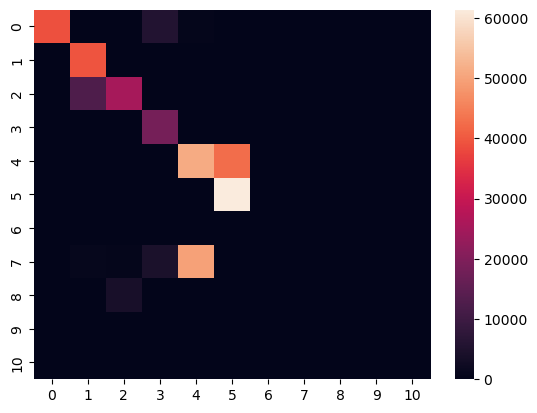

In [15]:
plt.figure()
sns.heatmap(roc_matrix)